In [1]:
%matplotlib inline

import random
import pandas as pd
import pylab
import numpy as np
import sklearn
from sklearn import linear_model
import sklearn.preprocessing as preprocessing
import math
import cvxpy as cp
import matplotlib.pyplot as plt

def data_transform(df):
    """Normalize features."""
    binary_data = pd.get_dummies(df)
    feature_cols = binary_data[binary_data.columns[:-2]]
    scaler = preprocessing.StandardScaler()
    data = pd.DataFrame(scaler.fit_transform(feature_cols), columns=feature_cols.columns)
    return data

In [2]:
features = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"] 
train_url = 'adult/adult.data'
test_url = 'adult/adult.test'

original_train = pd.read_csv(train_url, names=features, sep=r'\s*,\s*', 
                             engine='python', na_values="?")
original_test = pd.read_csv(test_url, names=features, sep=r'\s*,\s*', 
                            engine='python', na_values="?", skiprows=1)

In [3]:
flag = len(original_train)
org_train=original_train.sort_values(by="Age", ascending=False)
org_test=original_test.sort_values(by="Age", ascending=False)
original = pd.concat([org_train, org_test])
roc_original = original
labels = original['Target']
labels = labels.replace('<=50K', 0).replace('>50K', 1)
labels = labels.replace('<=50K.', 0).replace('>50K.', 1)
sensitive = original['Sex']
sensitive = sensitive.replace('Male', 0).replace('Female', 1)
# Redundant column
del original["Education"]
# Remove target variable
del original["Target"]
del original["Sex"]

In [4]:
data = data_transform(original)

train_data = data[:flag].values
train_labels = labels[:flag].values
test_data = data[flag:].values
test_labels = labels[flag:].values
P=train_data.shape[1]

In [5]:
def loss(X,Y,theta):
    eta=np.dot(X,theta)
    return -(np.dot(Y,eta)-np.sum(np.log(1+np.exp(eta))))

def f_grad(X,Y,theta):
    mu=1/(1+np.exp(-np.dot(X,theta)))
    return -(np.dot(X.T,Y-mu))+0.1*theta

def predict(theta,X):
    y =1/(1+np.exp(-np.dot(X,theta)))
    return np.array((y.T>0.5).reshape(-1)).astype(int)

def constraints(X,theta,z,c=1.0):
    length=z.shape[0]
    return np.concatenate((np.dot(z.T,np.dot(X,theta))/length-c,-np.dot(z.T,np.dot(X,theta))/length-c)).reshape(-1)

def g_grad(X,z):
    length=z.shape[0]
    tmp1=np.dot(z.T,X)/length
    tmp2=-np.dot(z.T,X)/length
    return np.concatenate((tmp1,tmp2),axis=0)

In [6]:
Z=sensitive.values
Z_mean=Z.mean()
Z_train=Z[:flag]
Z_test=Z[flag:]


In [7]:
def set_feature(Z_data,K):
    num=Z_data.shape[0]-(Z_data.shape[0]%10)
    tmp=np.zeros([num,K])
    idx=int(num/K)
    for i in range(K):
        tmp[idx*i:idx*(i+1),i]=1.0
    return np.concatenate(((Z_data[0:num]-Z_mean).reshape(-1,1),(tmp-0.2)),axis=1)

In [8]:
class center():
    def __init__(self,K,tau,eta):
        self.num=K
        self.tau=tau
        self.eta=eta
        self.lam=np.zeros(2*(self.num+1))
        self.theta=np.ones(P)*3
        #self.theta=np.zeros(P)
    def iteration(self):
        self.u=np.zeros(2*(self.num+1))
        self.f_grad=np.zeros(P)
        self.g_grad=np.zeros([2*(self.num+1),P])
    def get_data(self,u,f,g):
        self.u=self.u+u/self.num
        self.f_grad=self.f_grad+f/self.num
        self.g_grad=self.g_grad+g
    def get_theta(self):
        return self.theta
    def update(self):
        self.lam=self.lam+self.tau*self.u
        self.lam=np.maximum(0,self.lam)
        self.theta=self.theta-self.eta*(self.f_grad+np.dot(self.lam,self.g_grad))

In [9]:
class sever():
    def __init__(self,data,label,z_data,batch,K):
        self.data=data
        self.label=label
        self.z=z_data
        self.batch=batch
        self.len=data.shape[0]
        self.theta=np.ones(P)*3
        self.theta_p=np.ones(P)*3
        #self.theta=np.zeros(P)
        #self.theta_p=np.zeros(P)
        self.h2=np.zeros(2*(K+1))
        self.h1=np.zeros(2*(K+1))
    def get_data(self,theta):
        self.theta_p=self.theta
        self.theta=theta
    def send_u(self):
        return self.u
    def send_f(self):
        return self.f
    def send_g(self):
        return self.g
    def sample(self,c=1.0):
        rd=random.randint(0,self.len)
        if rd+self.batch>self.len:
            X=np.concatenate((self.data[rd:self.len],self.data[0:self.batch+rd-self.len]),axis=0)
            Y=np.concatenate((self.label[rd:self.len],self.label[0:self.batch+rd-self.len]),axis=0)
            z=np.concatenate((self.z[rd:self.len],self.z[0:self.batch+rd-self.len]),axis=0)
        else:
            X=self.data[rd:rd+self.batch]
            Y=self.label[rd:rd+self.batch]
            z=self.z[rd:rd+self.batch]
        self.h2=self.h1
        self.h1=constraints(X,self.theta_p,z,c)+np.dot(g_grad(X,z),(self.theta-self.theta_p))
        self.u=2*self.h1-self.h2
        self.f=f_grad(X,Y,self.theta)
        self.g=g_grad(X,z)

In [10]:
def centrilized(C1,C2,Batch,Epoch,b,c=1.0,K=5):
    tau=C1*math.sqrt(K*Batch)/math.sqrt(Epoch)
    eta=C2*math.sqrt(K*Batch)/math.sqrt(Epoch)
    Center=center(K,tau,eta)
    num=train_data.shape[0]-(train_data.shape[0]%K)
    data_part=np.split(train_data[0:num],K,axis=0)
    label_part=np.split(train_labels[0:num],K,axis=0)
    fair=set_feature(Z_train,K)
    fair_part=np.split(fair,K,axis=0)
    
    A=fair.T@(train_data[:fair.shape[0]]/fair.shape[0])
    A=np.concatenate((A,-A),axis=0)
    Sever=[]
    mselog=[]
    acclog=[]
    implog=[]
    Beta=np.zeros(P)
    for i in range(K):
        Sever.append(sever(data_part[i],label_part[i],fair_part[i],Batch,K))
    for i in range(Epoch):
        Center.iteration()
        for j in range(K):
            Sever[j].sample(c)
            Center.get_data(Sever[j].send_u(),Sever[j].send_f(),Sever[j].send_g())
        Center.update()
        for j in range(K):
            Sever[j].get_data(Center.get_theta())
        Beta=Beta+Center.get_theta()
        if i %10==0:
            tmp=Beta/(i+1)
            pred=predict(tmp,test_data)
            acc=sklearn.metrics.accuracy_score(pred,test_labels)
            impact=(A@tmp)-c
            #print(impact)
            acclog.append(acc)
            implog.append(np.linalg.norm(np.maximum(0,impact)))
            mselog.append(np.sum((b-tmp)**2)/P)
    return acclog,implog,mselog
    

In [23]:
acclog_K2,implog_K2,mselog_K2=centrilized(0.1,0.5,10,10000,star_K2,1.0,2)
acclog_K5,implog_K5,mselog_K5=centrilized(0.1,0.5,10,10000,star_K5,1.0,5)
acclog_K10,implog_K10,mselog_K10=centrilized(0.1,0.5,10,10000,star_K10,1.0,10)

In [137]:
mselog_K10[999]

0.044807918053196664

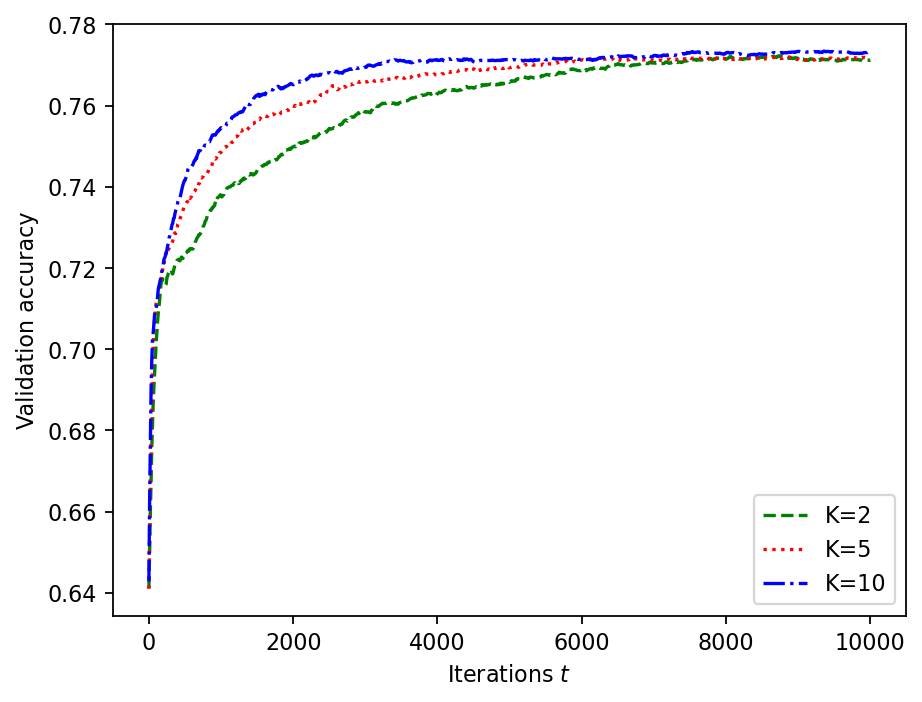

In [91]:
plt.figure(figsize=(6.4,4.8), dpi=160.0)
xline=np.linspace(1,10000,num=1000,endpoint=True)

plt.xlabel("Iterations $t$")  
plt.ylabel("Validation accuracy") 
plt.plot(xline,acclog_K2, linestyle = "--",color="g",label='K=2')
plt.plot(xline,acclog_K5, linestyle = ":",color="r",label='K=5')
plt.plot(xline,acclog_K10, linestyle = "-.",color="b",label='K=10')
plt.legend()
plt.show()

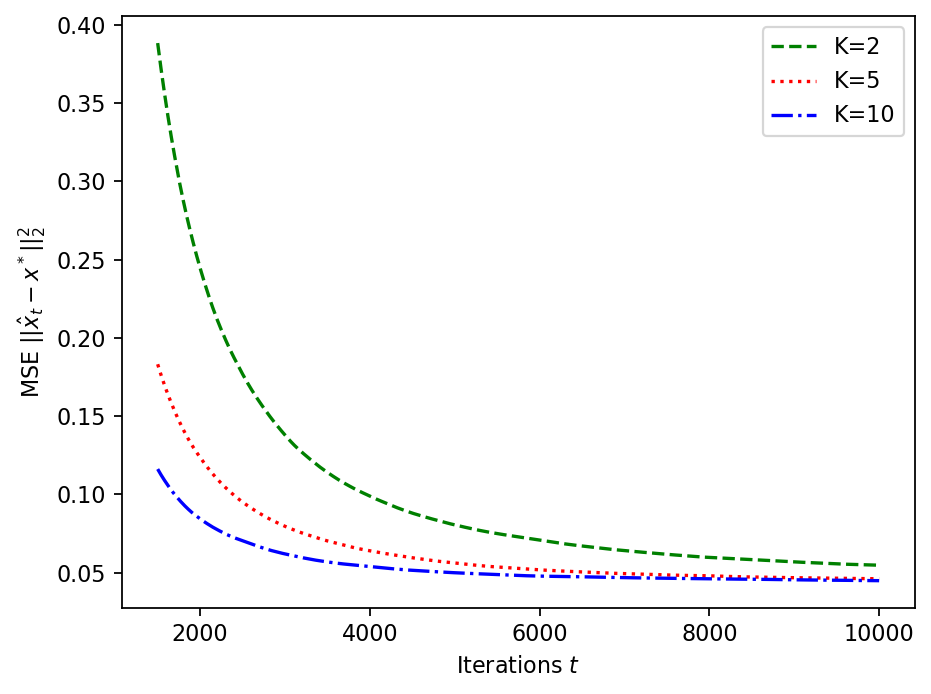

In [89]:
plt.figure(figsize=(6.4,4.8), dpi=160.0)
xline=np.linspace(1,10000,num=1000,endpoint=True)
plt.xlabel("Iterations $t$")  
plt.ylabel("MSE $\\|| \\hat x_t - x^* \\||_2^2$") 
plt.plot(xline[150:],mselog_K2[150:], linestyle = "--",color="g",label='K=2')
plt.plot(xline[150:],mselog_K5[150:], linestyle = ":",color="r",label='K=5')
plt.plot(xline[150:],mselog_K10[150:], linestyle = "-.",color="b",label='K=10')
plt.legend()

plt.show()

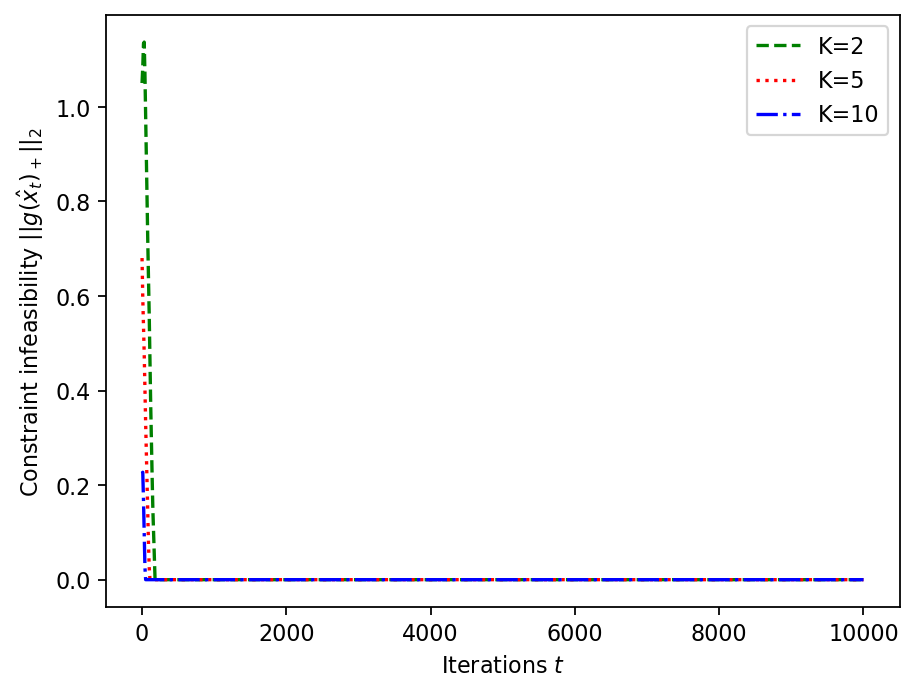

In [92]:
plt.figure(figsize=(6.4,4.8), dpi=160.0)
xline=np.linspace(1,10000,num=1000,endpoint=True)
plt.xlabel("Iterations $t$")  
plt.ylabel("Constraint infeasibility $ \\|| g(\\hat x_t)_+\\||_2 $" ) 
plt.plot(xline,implog_K2, linestyle = "--",color="g",label='K=2')
plt.plot(xline,implog_K5, linestyle = ":",color="r",label='K=5')
plt.plot(xline,implog_K10, linestyle = "-.",color="b",label='K=10')
plt.legend()

plt.show()

In [119]:
def centrilized_test(C1,C2,Batch,Epoch,b,c=1.0,K=5):
    tau=C1*math.sqrt(K*Batch)/math.sqrt(Epoch)
    eta=C2*math.sqrt(K*Batch)/math.sqrt(Epoch)
    Center=center(K,tau,eta)
    num=train_data.shape[0]-(train_data.shape[0]%K)
    data_part=np.split(train_data[0:num],K,axis=0)
    label_part=np.split(train_labels[0:num],K,axis=0)
    fair=set_feature(Z_train,K)
    fair_part=np.split(fair,K,axis=0)
    
    A=fair.T@(train_data[:fair.shape[0]]/fair.shape[0])
    A=np.concatenate((A,-A),axis=0)
    Sever=[]
    acc_log=[]
    Beta=np.zeros(P)
    for i in range(K):
        Sever.append(sever(data_part[i],label_part[i],fair_part[i],Batch,K))
    for i in range(Epoch):
        Center.iteration()
        for j in range(K):
            Sever[j].sample(c)
            Center.get_data(Sever[j].send_u(),Sever[j].send_f(),Sever[j].send_g())
        Center.update()
        for j in range(K):
            Sever[j].get_data(Center.get_theta())
        Beta=Beta+Center.get_theta()
        if i==99:
            tmp1=Beta/100
            #pred=predict(tmp,test_data)
            #acc_log.append(sklearn.metrics.accuracy_score(pred,test_labels))
        if i==999:
            tmp2=Beta/1000
            #pred=predict(tmp,test_data)
            #acc_log.append(sklearn.metrics.accuracy_score(pred,test_labels))
        if i==9999:
            tmp3=Beta/10000
            #pred=predict(tmp,test_data)
            #acc_log.append(sklearn.metrics.accuracy_score(pred,test_labels))
            
    return (tmp1,tmp2,tmp3)
    

In [131]:
Imp0,Imp1,Imp2=[],[],[]
Acc0,Acc1,Acc2=[],[],[]
J=[0.001,0.005,0.01,0.02,0.05]
for j in range(5):
    tmp=centrilized_test(0.01,0.5,10,10000,J[j],2)
    pred=predict(tmp[0],test_data)
    Acc0.append(sklearn.metrics.accuracy_score(pred,test_labels))
    pred=predict(tmp[1],test_data)
    Acc1.append(sklearn.metrics.accuracy_score(pred,test_labels))
    pred=predict(tmp[2],test_data)
    Acc2.append(sklearn.metrics.accuracy_score(pred,test_labels))
    Imp0.append(np.linalg.norm(A@tmp[0]))
    Imp1.append(np.linalg.norm(A@tmp[1]))
    Imp2.append(np.linalg.norm(A@tmp[2]))

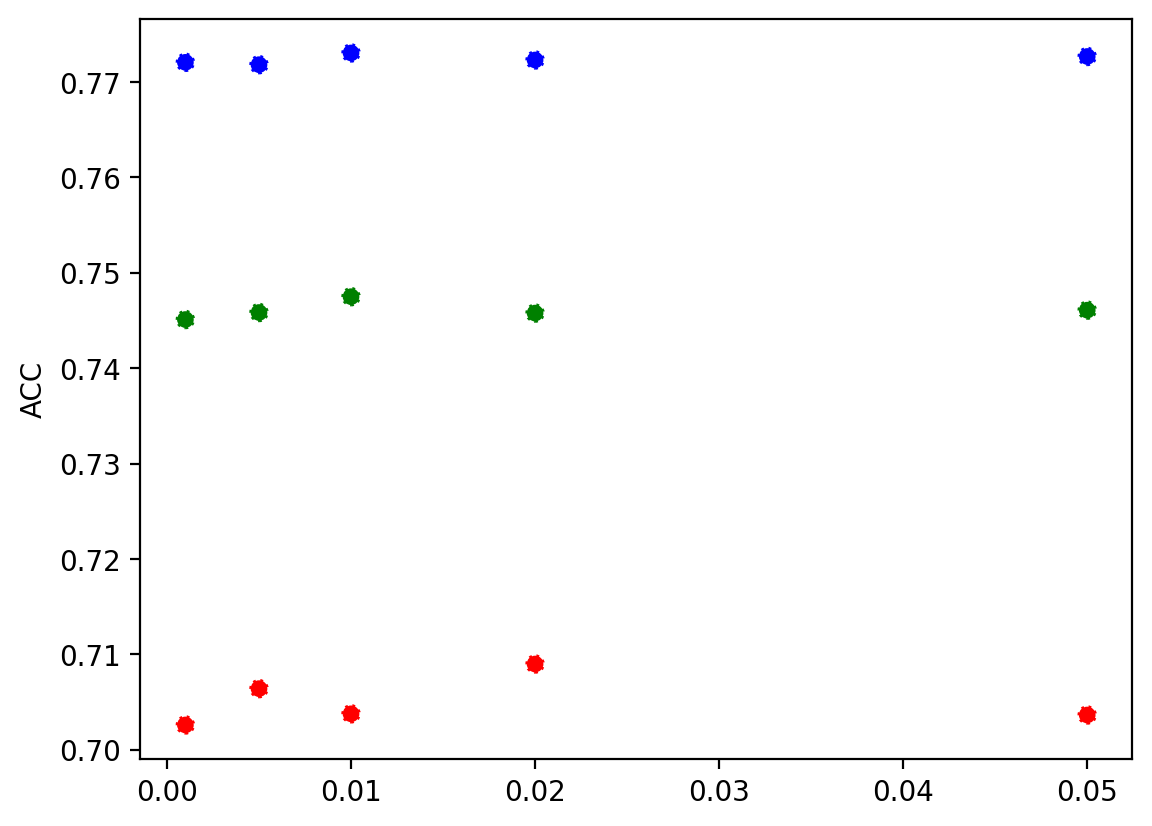

In [132]:
plt.figure(figsize=(6.4, 4.8), dpi=200.0)
plt.ylabel("ACC")
#xline=[0.2,0.4,0.6,0.8,1.0]
xline=np.array(J)
plt.scatter(xline,Acc0, linestyle = ":",color="r")
plt.scatter(xline,Acc1, linestyle = ":",color="g")
plt.scatter(xline,Acc2, linestyle = ":",color="b")
#plt.plot(mse, linestyle = ":",color="gray")
#plt.legend()
plt.show()

In [96]:
accurracy[1]

[0.702475277931331, 0.7436889625944352, 0.7718199127817702]

16281

In [112]:
Beta_true=[]
num=train_data.shape[0]-(train_data.shape[0]%5)
fair=set_feature(Z_train,5)
A=fair.T@train_data[0:num]
A=np.concatenate((A,-A),axis=0)/num

for j in range(5):
    
    c=np.ones(12)*J[j]
    beta = cp.Variable(P)
    log_likelihood = cp.sum(
    cp.multiply(train_labels,train_data @ beta) - cp.logistic(train_data @ beta)
    )
    problem = cp.Problem(cp.Maximize(log_likelihood/len(train_labels)-0.05*cp.sum_squares(beta)),[A @ beta <= c])
    problem.solve()
    Beta_true.append(beta.value)
    

In [127]:
true_accurracy=[]
true_impact=[]
for j in range(5):
    pred=predict(Beta_true[j],train_data)
    true_accurracy.append(sklearn.metrics.accuracy_score(pred,train_labels))
    true_impact.append(np.linalg.norm(A@Beta_true[j]))

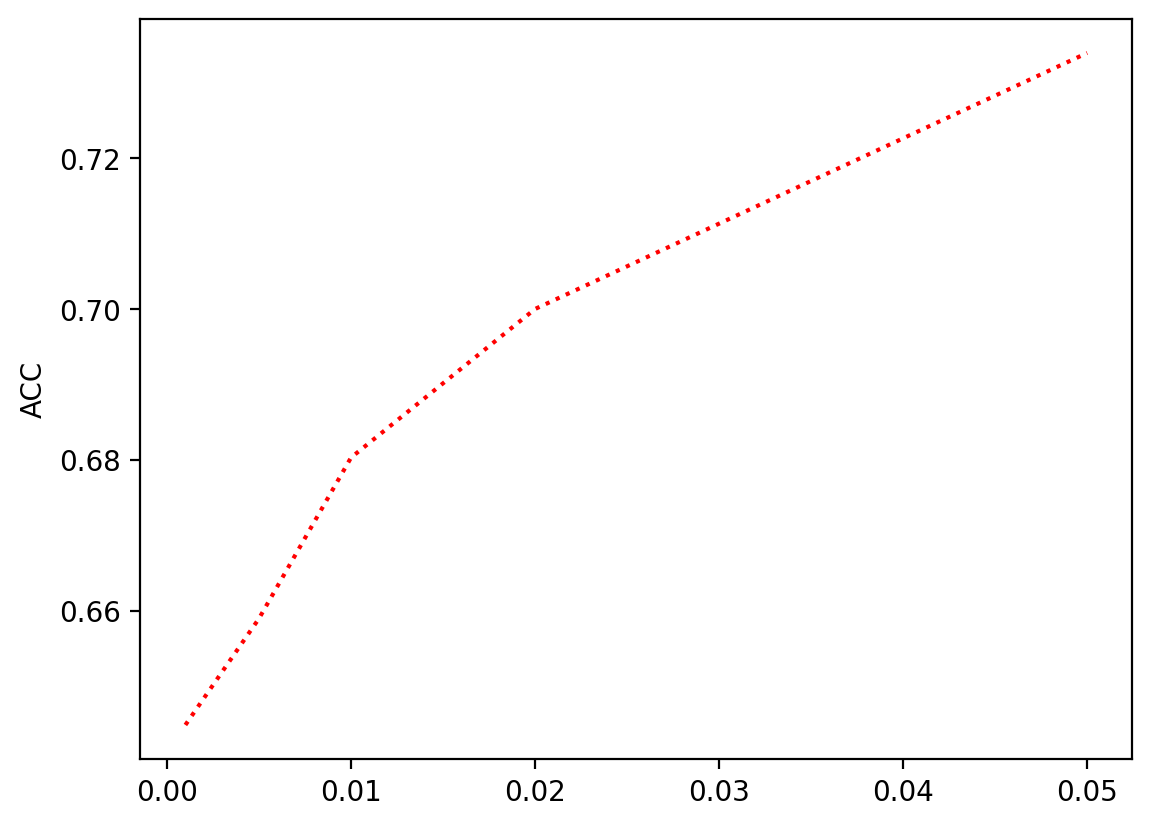

In [130]:
plt.figure(figsize=(6.4, 4.8), dpi=200.0)
#plt.title("Star Network: MSE of $ \\beta_t $ and $ \\beta^*$ ")
#plt.xlabel("$\\times$10 gradient descent steps")  
plt.ylabel("ACC")
xline=np.array(J)
plt.plot(xline,true_accurracy, linestyle = ":",color="r")

plt.show()

In [44]:
class agent():
    def __init__(self,data,label,z_data,batch,tau,eta,idx,K):
        self.data=data
        self.label=label
        self.z=z_data
        self.batch=batch
        self.len=data.shape[0]
        self.tau=tau
        self.eta=eta
        self.lam=np.zeros(2*(K+1))
        self.theta=np.ones(P)*2.5
        self.theta_h=np.ones(P)*2.5
        self.theta_ph=np.ones(P)*2.5
        self.theta_p=np.ones(P)*2.5
        self.idx=idx
    def get_lam(self,LAM):
        self.lam=LAM[self.idx]
    def get_theta(self,THETA):
        self.theta_ph=self.theta_h
        self.theta_h=THETA[self.idx]
    def send_lam(self,LAM):
        LAM[self.idx]=self.lam
    def send_theta(self,THETA):
        THETA[self.idx]=self.theta

    def sample_lam(self):
        rd=random.randint(0,self.len)
        if rd+self.batch>self.len:
            X=np.concatenate((self.data[rd:self.len],self.data[0:self.batch+rd-self.len]),axis=0)
            z=np.concatenate((self.z[rd:self.len],self.z[0:self.batch+rd-self.len]),axis=0)
        else:
            X=self.data[rd:rd+self.batch]
            z=self.z[rd:rd+self.batch]
        h1=constraints(X,self.theta_h,z)+np.dot(g_grad(X,z),(self.theta-self.theta_h))
        h2=constraints(X,self.theta_ph,z)+np.dot(g_grad(X,z),(self.theta_p-self.theta_ph))
        self.lam=np.maximum(0,self.lam+self.tau*(2*h1-h2))
        
    def sample_theta(self):
        rd=random.randint(0,self.len)
        if rd+self.batch>self.len:
            X=np.concatenate((self.data[rd:self.len],self.data[0:self.batch+rd-self.len]),axis=0)
            Y=np.concatenate((self.label[rd:self.len],self.label[0:self.batch+rd-self.len]),axis=0)
            z=np.concatenate((self.z[rd:self.len],self.z[0:self.batch+rd-self.len]),axis=0)
        else:
            X=self.data[rd:rd+self.batch]
            Y=self.label[rd:rd+self.batch]
            z=self.z[rd:rd+self.batch]
        self.theta=self.theta_h-self.eta*(f_grad(X,Y,self.theta_h)+np.dot(self.lam,g_grad(X,z)))        
        
    def get_res(self):
        return self.theta

In [45]:
def decentrilized(C1,C2,Batch,Epoch,b,c=1.0,K=5):
    datalog=[]
    tau=C1*math.sqrt(K)/math.sqrt(Epoch)
    eta=C2*math.sqrt(K)/math.sqrt(Epoch)
    num=train_data.shape[0]-(train_data.shape[0]%K)
    data_part=np.split(train_data[0:num],K,axis=0)
    label_part=np.split(train_labels[0:num],K,axis=0)
    fair=set_feature(Z_train,K)
    fair_part=np.split(fair,K,axis=0)
    Agent=[]
    acclog,implog,mselog=[],[],[]
    LAM=np.zeros([K,2*(K+1)])
    THETA=np.zeros([K,P])
    W=gossip_matrix(K)
    beta=np.zeros(P)
    A=fair.T@(train_data[:fair.shape[0]]/fair.shape[0])
    A=np.concatenate((A,-A),axis=0)

    for i in range(K):
        Agent.append(agent(data_part[i],label_part[i],fair_part[i],Batch,tau,eta,i,K))
    for i in range(Epoch):
        for j in range(K):
            Agent[j].send_lam(LAM)
        for s in range(int(math.log(K))+1):
            LAM=np.dot(W,LAM)
        for j in range(K):
            Agent[j].get_lam(LAM)
            Agent[j].sample_lam()
            Agent[j].send_theta(THETA)
        THETA=np.dot(W,THETA)
        for j in range(K):
            Agent[j].get_theta(THETA)
            Agent[j].sample_theta()
        for j in range(K):
                tmp_theta=Agent[j].get_res()
                beta=beta+tmp_theta/K
        if i%10 == 0:
            tmp=beta/(i+1)
            pred=predict(tmp,test_data)
            acc=sklearn.metrics.accuracy_score(pred,test_labels)
            impact=(A@tmp)-c
            acclog.append(acc)
            implog.append(np.linalg.norm(np.maximum(0,impact)))
            mselog.append(np.sum((b-tmp)**2)/P)
    return acclog,implog,mselog

In [46]:
def gossip_matrix(K):
    W=np.random.normal(loc=1,scale=1,size=(K,K))
    for i in range(K):
        temp=np.sum(W[i])
        W[i]=W[i]/temp
    return W

In [59]:
accLog_K2,impLog_K2,mseLog_K2=decentrilized(0.1,0.5,10,10000,star_K2,1.0,2)
accLog_K5,impLog_K5,mseLog_K5=decentrilized(0.1,0.5,10,10000,star_K5,1.0,5)
accLog_K10,impLog_K10,mseLog_K10=decentrilized(0.1,0.5,10,10000,star_K10,1.0,10)

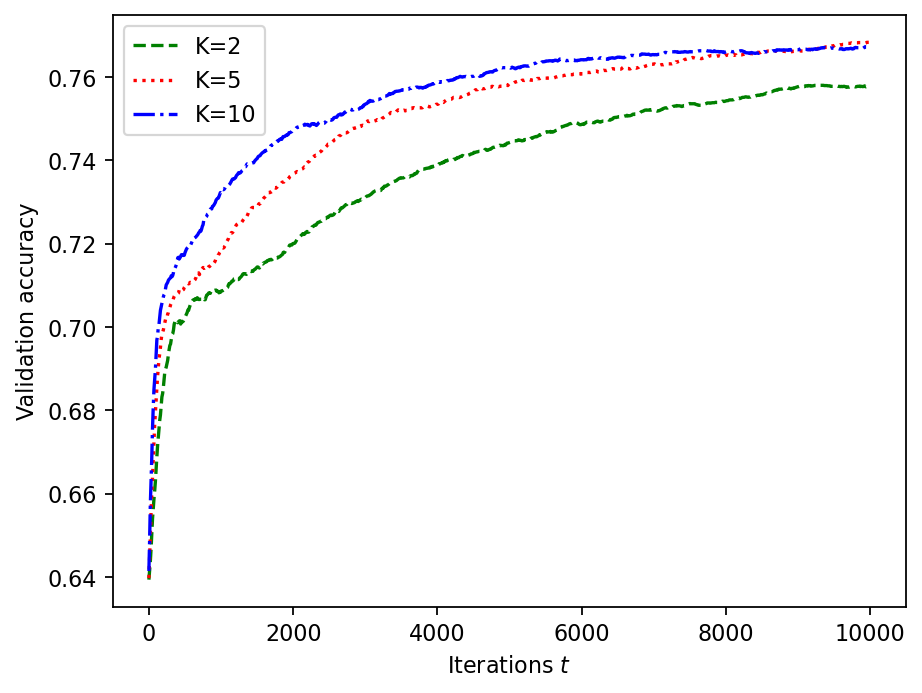

In [124]:
plt.figure(figsize=(6.4,4.8), dpi=160.0)
xline=np.linspace(1,10000,num=1000,endpoint=True)

plt.xlabel("Iterations $t$")  
plt.ylabel("Validation accuracy") 
plt.plot(xline,accLog_K2, linestyle = "--",color="g",label='K=2')
plt.plot(xline,accLog_K5, linestyle = ":",color="r",label='K=5')
plt.plot(xline,accLog_K10, linestyle = "-.",color="b",label='K=10')
plt.legend()

plt.show()

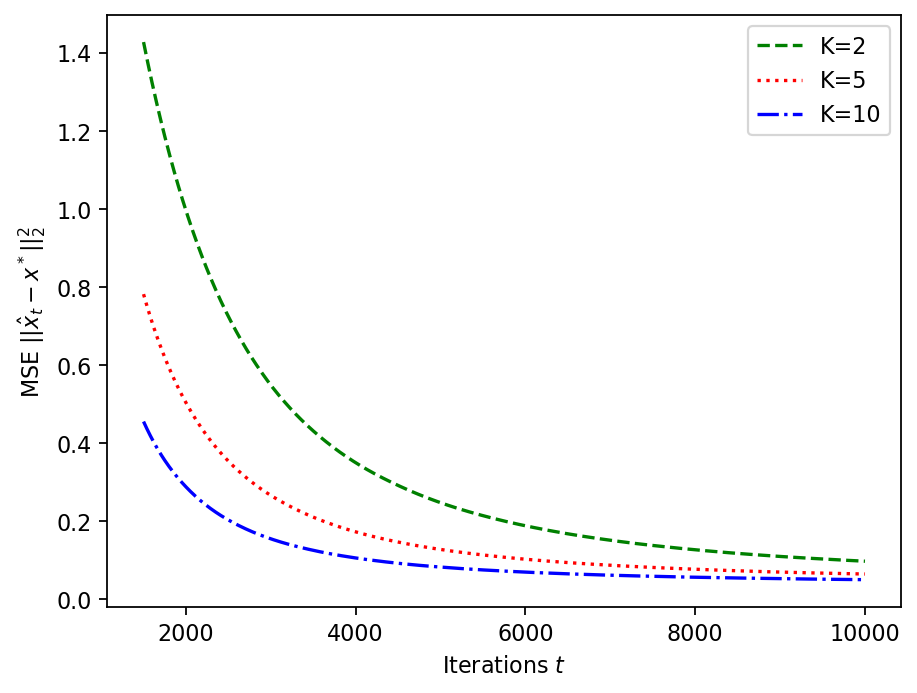

In [94]:
plt.figure(figsize=(6.4,4.8), dpi=160.0)
xline=np.linspace(1,10000,num=1000,endpoint=True)

plt.xlabel("Iterations $t$")  
plt.ylabel("MSE $\\|| \\hat x_t - x^* \\||_2^2$") 
plt.plot(xline[150:],mseLog_K2[150:], linestyle = "--",color="g",label='K=2')
plt.plot(xline[150:],mseLog_K5[150:], linestyle = ":",color="r",label='K=5')
plt.plot(xline[150:],mseLog_K10[150:], linestyle = "-.",color="b",label='K=10')
plt.legend()

plt.show()

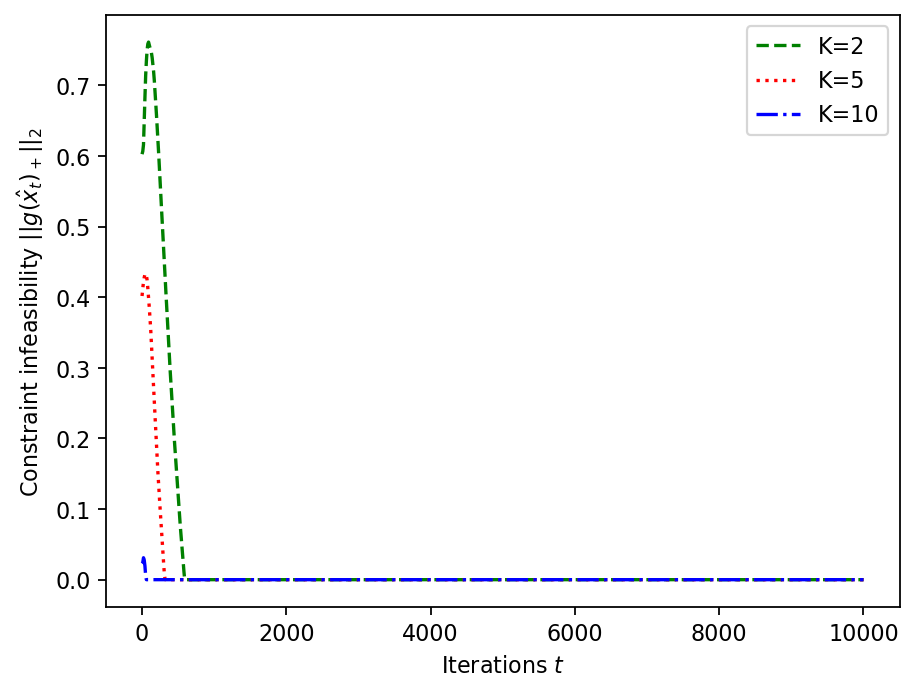

In [95]:
plt.figure(figsize=(6.4,4.8), dpi=160.0)
xline=np.linspace(1,10000,num=1000,endpoint=True)

plt.xlabel("Iterations $t$")  
plt.ylabel("Constraint infeasibility $ \\||g(\\hat x_t)_+\\||_2 $") 

plt.plot(xline,impLog_K2, linestyle = "--",color="g",label='K=2')
plt.plot(xline,impLog_K5, linestyle = ":",color="r",label='K=5')
plt.plot(xline,impLog_K10, linestyle = "-.",color="b",label='K=10')
plt.legend()



plt.show()

In [254]:
beta = cp.Variable(P)
log_likelihood = cp.sum(
    cp.multiply(train_labels,train_data @ beta) - cp.logistic(train_data @ beta)
    )
problem = cp.Problem(cp.Maximize(log_likelihood/len(train_labels)))
problem.solve()
star=beta.value

In [261]:
np.linalg.norm(A@star)/12

2782.156331707273

In [18]:
c=np.ones(6)
fair=set_feature(Z_train,2)
A=fair.T@train_data[0:fair.shape[0]]
A=np.concatenate((A,-A),axis=0)/fair.shape[0]
beta = cp.Variable(P)
log_likelihood = cp.sum(
    cp.multiply(train_labels,train_data @ beta) - cp.logistic(train_data @ beta)
    )
problem = cp.Problem(cp.Maximize(log_likelihood/len(train_labels)-0.05*cp.sum_squares(beta)),[A @ beta <= c])
problem.solve()
star_K2=beta.value

In [12]:
c=np.ones(12)
fair=set_feature(Z_train,5)
A=fair.T@train_data[0:fair.shape[0]]
A=np.concatenate((A,-A),axis=0)/fair.shape[0]
beta = cp.Variable(P)
log_likelihood = cp.sum(
    cp.multiply(train_labels,train_data @ beta) - cp.logistic(train_data @ beta)
    )
problem = cp.Problem(cp.Maximize(log_likelihood/len(train_labels)-0.05*cp.sum_squares(beta)),[A @ beta <= c])
problem.solve()
star_K5=beta.value

In [21]:
c=np.ones(22)
fair=set_feature(Z_train,10)
A=fair.T@train_data[0:fair.shape[0]]
A=np.concatenate((A,-A),axis=0)/fair.shape[0]
beta = cp.Variable(P)
log_likelihood = cp.sum(
    cp.multiply(train_labels,train_data @ beta) - cp.logistic(train_data @ beta)
    )
problem = cp.Problem(cp.Maximize(log_likelihood/len(train_labels)-0.05*cp.sum_squares(beta)),[A @ beta <= c])
problem.solve()
star_K10=beta.value

In [13]:
pred=predict(star_K5,test_data)
print(sklearn.metrics.accuracy_score(pred,test_labels))

0.7214544561144893


In [53]:
np.ones(10)*3

array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3.])